In [32]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval

In [33]:
def evaluate_classifier(model, X_test, y_test, labels=None):
    
    pred = model.predict(X_test) 

    print(classification_report(y_test, pred))
    print("Accuracy  = " + str(accuracy_score(y_true=y_test, y_pred=pred)))
    print("Precision = " + str(precision_score(y_true=y_test, y_pred=pred, average='weighted')))
    print("Recall    = " + str(recall_score(y_true=y_test, y_pred=pred, average='weighted')))
    print("F1 score  = " + str(f1_score(y_true=y_test, y_pred=pred, average='weighted')))

    fig, ax = plt.subplots(figsize=(8,6))
    cm = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax)
    plt.grid(False)
    plt.show()

In [34]:
RANDOM_STATE = 12345

In [35]:
traindf = pd.read_csv('../data/train_data.csv')
traindf['tokenized'] = traindf['tokenized'].apply(literal_eval)
traindf['lemmatized'] = traindf['lemmatized'].apply(literal_eval)

In [36]:
testdf = pd.read_csv('../data/test_data.csv')
testdf['tokenized'] = testdf['tokenized'].apply(literal_eval)
testdf['lemmatized'] = testdf['lemmatized'].apply(literal_eval)

In [37]:
LABELS = traindf.genre.unique().tolist()
print(LABELS)

['country', 'reggae', 'disco', 'pop', 'blues', 'hiphop', 'rock', 'metal']


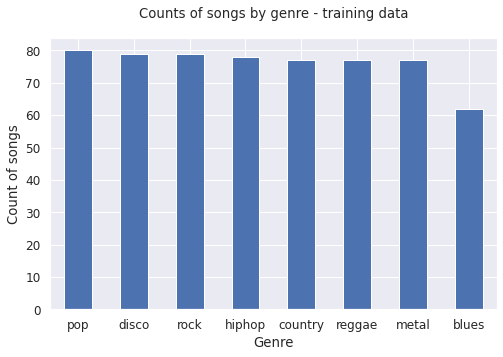

In [38]:
sns.set(font_scale=1.1)
traindf['genre'].value_counts().plot(kind='bar', rot=0, figsize=(8,5))
plt.xlabel("Genre")
plt.ylabel("Count of songs")
plt.title("Counts of songs by genre - training data", y=1.05)
plt.show()

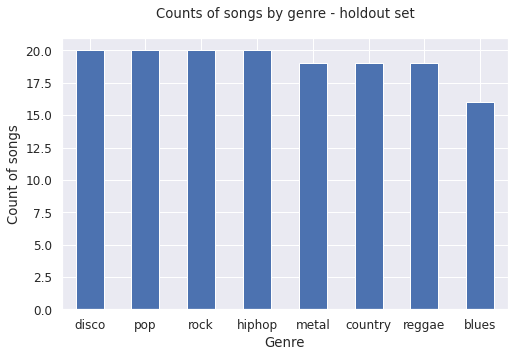

In [39]:
sns.set(font_scale=1.1)
testdf['genre'].value_counts().plot(kind='bar', rot=0, figsize=(8,5))
plt.xlabel("Genre")
plt.ylabel("Count of songs")
plt.title("Counts of songs by genre - holdout set", y=1.05)
plt.show()

In [40]:
X_train = traindf['tokenized']
y_train = traindf['genre']
X_test = testdf['tokenized']
y_test = testdf['genre']

## Bayes

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [42]:
def dummy_fun(doc):
    return doc

In [49]:
# Pipeline & Gridsearch setup
# TFIDF pipeline setup
tvc_pipe = Pipeline([
    ('tvec', CountVectorizer(tokenizer=dummy_fun, preprocessor=dummy_fun)),
    ('mb', MultinomialNB())
])

# Randomforest pipeline setup
rf_pipe = Pipeline([
    ('tvec', CountVectorizer(tokenizer=dummy_fun, preprocessor=dummy_fun)),
    ('rf', RandomForestClassifier(random_state=RANDOM_STATE))
])

# Fit
tvc_pipe.fit(X_train, y_train)
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('tvec',
                 CountVectorizer(preprocessor=<function dummy_fun at 0x7f9e4a841430>,
                                 tokenizer=<function dummy_fun at 0x7f9e4a841430>)),
                ('rf', RandomForestClassifier(random_state=12345))])

              precision    recall  f1-score   support

       blues       0.67      0.25      0.36        16
     country       0.47      0.42      0.44        19
       disco       0.43      0.30      0.35        20
      hiphop       0.62      0.90      0.73        20
       metal       0.67      0.42      0.52        19
         pop       0.29      0.55      0.38        20
      reggae       0.75      0.63      0.69        19
        rock       0.38      0.40      0.39        20

    accuracy                           0.49       153
   macro avg       0.53      0.48      0.48       153
weighted avg       0.53      0.49      0.49       153

Accuracy  = 0.49019607843137253
Precision = 0.5288774691637683
Recall    = 0.49019607843137253
F1 score  = 0.4852381394108844


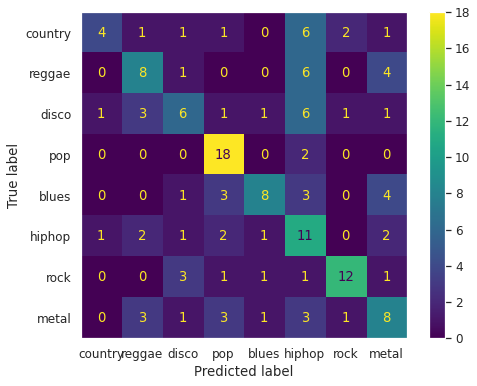

In [50]:
evaluate_classifier(tvc_pipe, X_test, y_test, LABELS)

              precision    recall  f1-score   support

       blues       0.59      0.62      0.61        16
     country       0.34      0.63      0.44        19
       disco       0.34      0.55      0.42        20
      hiphop       0.89      0.85      0.87        20
       metal       0.64      0.47      0.55        19
         pop       0.69      0.45      0.55        20
      reggae       0.86      0.63      0.73        19
        rock       0.44      0.20      0.28        20

    accuracy                           0.55       153
   macro avg       0.60      0.55      0.55       153
weighted avg       0.60      0.55      0.55       153

Accuracy  = 0.5490196078431373
Precision = 0.6008550980216737
Recall    = 0.5490196078431373
F1 score  = 0.5532483693403234


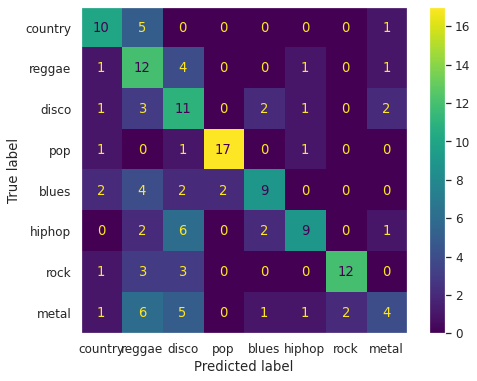

In [51]:
evaluate_classifier(rf_pipe, X_test, y_test, LABELS)

In [ ]:
# Setting params for TFIDF Vectorizer gridsearch
tf_params = {
    'tvec__tokenizer':[dummy_fun],
    'tvec__preprocessor':[dummy_fun],
    'tvec__max_features':[None, 100, 2000],
    'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'mb__alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100, 1000],
}
# Setting up randomforest params
rf_params = {
    'tvec__tokenizer':[dummy_fun],
    'tvec__preprocessor':[dummy_fun],
    'tvec__max_features':[None, 100, 2000],
    'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'rf__n_estimators': [50, 100, 200, 500],
    'rf__criterion': ['log_loss', 'gini', 'entropy'],
    'rf__max_depth': [None, 3, 5, 10],
    'rf__min_samples_split': [2, 5, 10],
    'rf__max_features': [None, 'sqrt', 'log2'],
}

# Setting up GridSearch for Randomforest
rf_gs = GridSearchCV(rf_pipe, param_grid=rf_params, cv = 5, verbose = 1, n_jobs = -1)
# Setting up GridSearch for TFIDFVectorizer
tvc_gs = GridSearchCV(tvc_pipe, param_grid=tf_params, cv = 5, verbose =1, n_jobs = -1)
# Fitting TVC GS
tvc_gs.fit(X_train, y_train)
# Fitting Randomforest CV GS
rf_gs.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 3888 candidates, totalling 19440 fits


In [ ]:
print("Best Bayes CV score = %0.3f with the following parameters:" % tvc_gs.best_score_)
print(tvc_gs.best_params_)
print("")
print("Best RandomForest CV score = %0.3f with the following parameters:" % rf_gs.best_score_)
print(rf_gs.best_params_)

In [ ]:
evaluate_classifier(tvc_gs, X_test, y_test, LABELS)

In [ ]:
evaluate_classifier(rf_gs, X_test, y_test, LABELS)